# Лабораторная работа 5

**«Методы машинного обучения»**

**Постановка задачи**:

Заказчик – кредитный отдел банка, входные данные от банка — статистика о платёжеспособности клиентов. Требуется построить модель кредитного скоринга, которая позволит оценить способность потенциального заёмщика вернуть кредит банку.

**Описание данных:**

* children – количество детей в семье;

* days_employed – общий трудовой стаж в днях;

* dob_years – возраст клиента в годах;

* education – уровень образования клиента;

* education_id – идентификатор уровня образования;

* family_status – семейное положение;

* family_status_id – идентификатор семейного положения;

* gender – пол клиента;

* income_type – тип занятости;

* debt – имел ли задолженность по возврату кредитов (1 – имел, 0 – не имел);

* total_income – ежемесячный доход;

* purpose – цель получения кредита.

**Задания:**

1. Выполнить сегментацию клиентов, имеющих задолженность по кредитам, не имеющих задолженность по кредитам (для всей совокупности количесвенных данных после предобработки):

    * построить дендограмму;

    * определить оптимальное число кластеров;

    * выполнить кластеризацию;

    * оценить качество кластеризации (рассмотреть метрики силуэта, Индекс Калински-Харабаса, Индекс Дэвиса-Болдина) 
    
1. Построить портреты клиентов.

1. Постройте модель логистической регрессии на основе всей совокупности данных:

    * выполните кодирование переменных (.get_dummies(df)), 

    * выполните трансформацию (нормировку) переменных (StandardScaler),

    * разбейте набор данных на матрицу объясняющих переменных и вектор значений целевой переменной,

    * оценить качество построенного уравнения регрессии.

1. Сформируйте сбалансированную выборку, выполните п.2 для сбалансированной выборки.  

1. Сформируйте выборки наблюдений по целям кредитования. Постройте модели логистической регрессии по сформированным выборкам наблюдений в зависимости от целей кредитования. Оцените качество построенных уравнений регрессии. Сделайте выводы.

1. Постройте модель дерева решений. Оцените качество построенной модели.

In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from numpy import argmax
import seaborn as sns

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc, classification_report, silhouette_score
from sklearn.decomposition import PCA
from scikitplot.metrics import plot_roc, plot_precision_recall, roc_curve
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## 1. Выполнить сегментацию клиентов, имеющих задолженность по кредитам, не имеющих задолженность по кредитам (для всей совокупности количесвенных данных после предобработки):

* построить дендограмму;

* определить оптимальное число кластеров;

* выполнить кластеризацию;

* оценить качество кластеризации (рассмотреть метрики силуэта, Индекс Калински-Харабаса, Индекс Дэвиса-Болдина) 

In [2]:
dataframe = pd.read_csv("./data/data_correct.csv", index_col=0).iloc[:, :12]
print(dataframe.shape)
dataframe.head()

(19350, 12)


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,0.770564,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,жильё
1,1,0.367562,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,автомобиль
2,0,0.513555,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,жильё
3,3,0.376689,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,образование
4,0,31.074527,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,свадьба


In [3]:
dataframe.dtypes

children              int64
days_employed       float64
dob_years             int64
education            object
education_id          int64
family_status        object
family_status_id      int64
gender               object
income_type          object
debt                  int64
total_income        float64
purpose              object
dtype: object

In [7]:
# Делим датасет на debt=0 и debt=1
dataframe_debt_0 = dataframe[dataframe["debt"] == 0]
dataframe_debt_1 = dataframe[dataframe["debt"] == 1]

In [8]:
# Нормализуем данные для debt=0
dataframe_debt_0 = dataframe_debt_0[[
    'children',
    'days_employed',
    'dob_years',
    'education_id',
    'family_status_id',
    'total_income',
    'debt'
]]
scaler = MinMaxScaler()
X_0 = dataframe_debt_0.drop(['debt'], axis=1)
X_0_norm = scaler.fit_transform(X_0)
dataset1 = pd.DataFrame(X_0_norm, columns=[
    'children',
    'days_employed',
    'dob_years',
    'education_id',
    'family_status_id',
    'total_income'
])
dataset1.round(2).head()

,children,days_employed,dob_years,education_id,family_status_id,total_income
0,0.2,0.02,0.41,0.00,0.00,0.10
1,0.2,0.01,0.30,0.25,0.00,0.04
2,0.0,0.01,0.25,0.25,0.00,0.06
3,0.6,0.01,0.23,0.25,0.00,0.11
4,0.0,0.85,0.61,0.25,0.25,0.06


In [9]:
# Нормализуем данные для debt=1
dataframe_debt_1 = dataframe_debt_1[[
    'children',
    'days_employed',
    'dob_years',
    'education_id',
    'family_status_id',
    'total_income',
    'debt'
]]
scaler = MinMaxScaler()
X_1 = dataframe_debt_1.drop(['debt'], axis=1)
X_1_norm = scaler.fit_transform(X_1)
dataset2 = pd.DataFrame(X_1_norm, columns=[
    'children',
    'days_employed',
    'dob_years',
    'education_id',
    'family_status_id',
    'total_income'
])
dataset2.round(2).head()

,children,days_employed,dob_years,education_id,family_status_id,total_income
0,0.00,0.00,0.70,0.00,0.25,0.07
1,0.00,0.01,0.28,0.33,0.25,0.05
2,0.00,0.00,0.11,0.00,1.00,0.08
3,0.25,0.01,0.36,0.33,0.00,0.03
4,0.25,0.00,0.25,0.33,0.00,0.14


### Дендограмма

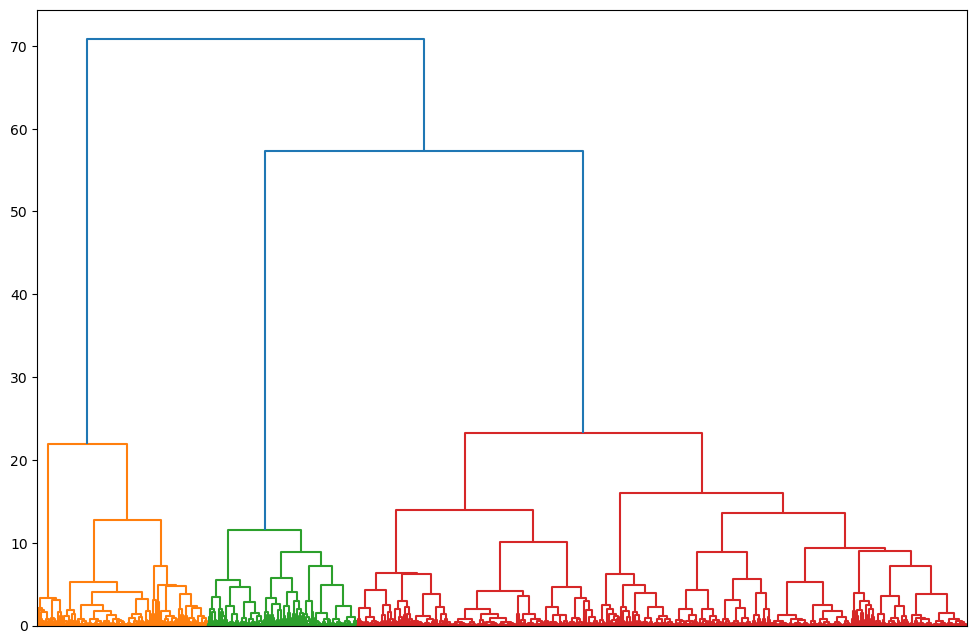

In [10]:
# Для debt=0

d = linkage(X_0_norm, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(d, orientation='top', no_labels=True)
plt.show()

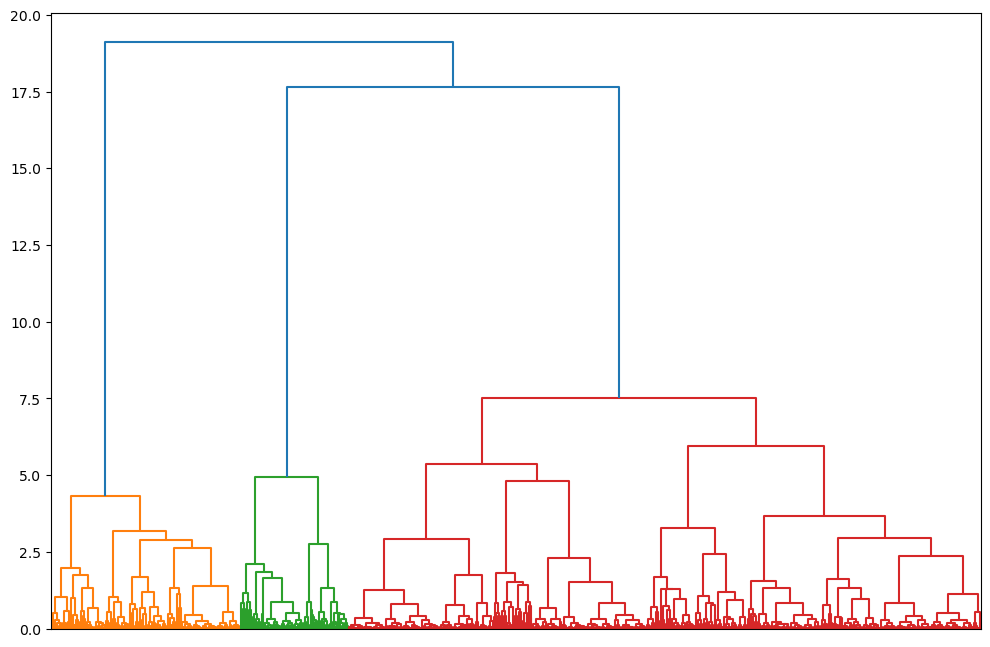

In [11]:
# Для debt=1

d = linkage(X_1_norm, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(d, orientation='top', no_labels=True)
plt.show()

### Определить оптимальное число кластеров

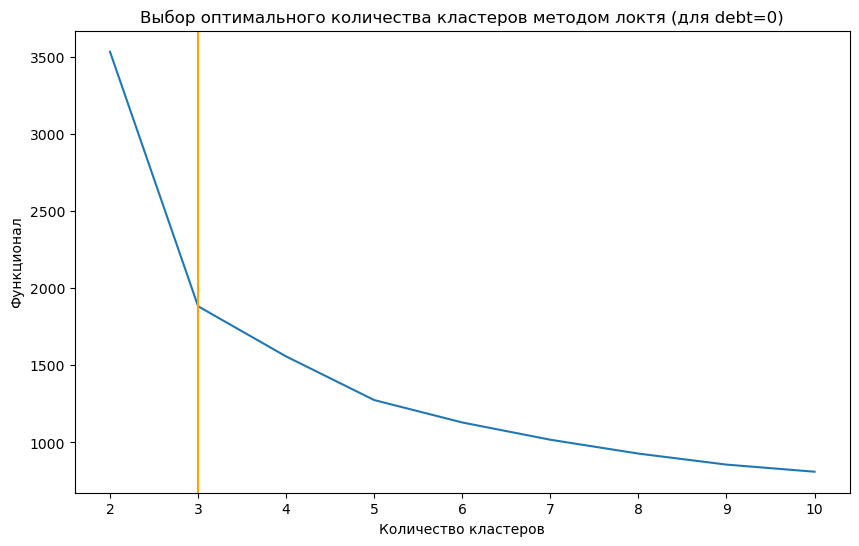

In [31]:
# Определим число кластеров для debt=0

# создадим пустой список для записи функционала f
f = []
sil = []

for i in range(2, 11):
    # настроим параметры модели
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=42)
    # обучим модель на нормированных данных для разного числа кластеров
    # kmeans.fit(X_0_norm)
    preds = kmeans.fit_predict(X_0_norm)
    # для каждого кластера рассчитаем функционал (атрибут inertia_) и поместим в список
    f.append(kmeans.inertia_)
    sil.append(silhouette_score(X_0, preds))

# зададим размер график
plt.figure(figsize=(10, 6))
# передадим функции plot() последовательность кластеров и функционал
plt.plot(range(2, 11), f)
x_ticks = range(2, 11)

plt.xticks(ticks=x_ticks)
plt.axvline(x=3, color="orange")
# задаем названия графика и осей
plt.title('Выбор оптимального количества кластеров методом локтя (для debt=0)')
plt.xlabel('Количество кластеров')
plt.ylabel('Функционал')
plt.show()

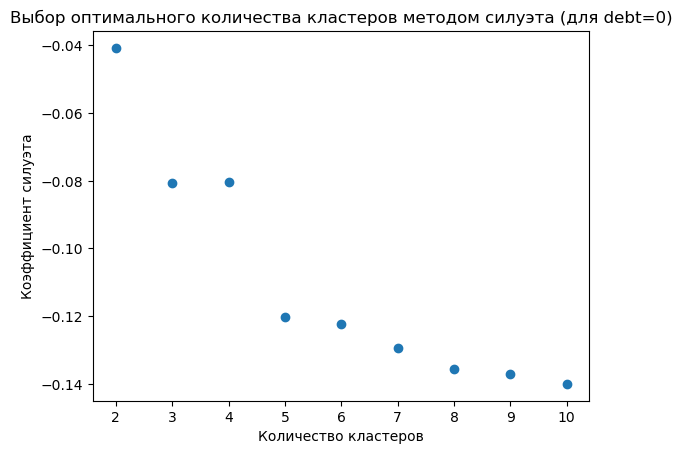

In [32]:
plt.scatter(range(2, 11), sil)
plt.title('Выбор оптимального количества кластеров методом силуэта (для debt=0)')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.show()

**Вывод:**

   *  Как видно из метода Локтя, резкое падение функционала находится при количестве класетров равное 3 и 4
   
   *  Как видно из метода Силуэта, наивысшее значение коэффициента находится для двух класетров, но и у 3-4 кластеров не слишком низкие значения (относительно).
   
   * В сосвокупности 2-х методов оптимальное количетство кластеров равно 3

Text(0, 0.5, 'Функционал')

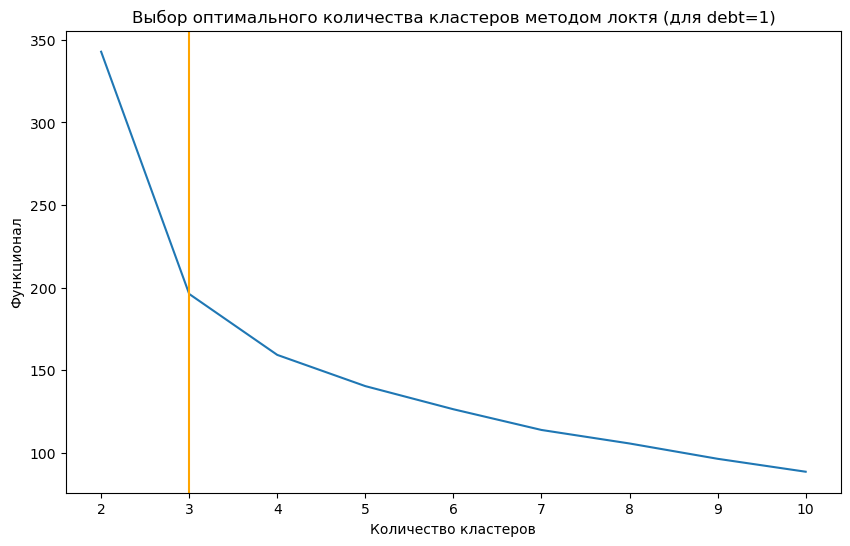

In [26]:
# Определим число кластеров для debt=1

# создадим пустой список для записи функционала f
f = []
sil = []

for i in range(2, 11):
    # настроим параметры модели
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=42)
    # обучим модель на нормированных данных для разного числа кластеров
    # kmeans.fit(X_0_norm)
    preds = kmeans.fit_predict(X_1_norm)
    # для каждого кластера рассчитаем функционал (атрибут inertia_) и поместим в список
    f.append(kmeans.inertia_)
    sil.append(silhouette_score(X_1, preds))

# зададим размер график
plt.figure(figsize=(10, 6))
# передадим функции plot() последовательность кластеров и функционал
plt.plot(range(2, 11), f)
x_ticks = range(2, 11)

plt.xticks(ticks=x_ticks)
plt.axvline(x=3, color="orange")
# задаем названия графика и осей
plt.title('Выбор оптимального количества кластеров методом локтя (для debt=1)')
plt.xlabel('Количество кластеров')
plt.ylabel('Функционал')
plt.show()

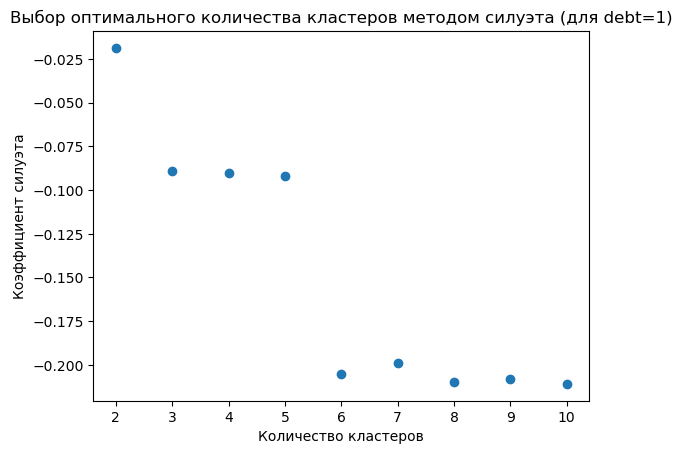

In [30]:
plt.scatter(range(2, 11), sil)
plt.title('Выбор оптимального количества кластеров методом силуэта (для debt=1)')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.show()

**Вывод:**

   *  Как видно из метода Локтя, резкое падение функционала находится при количестве класетров равное 3 и 4
   
   *  Как видно из метода Силуэта, наивысшее значение коэффициента находится для двух класетров, но и у 3-5 кластеров не слишком низкие значения (относительно).
   
   * В сосвокупности 2-х методов оптимальное количетство кластеров равно 3

In [17]:
# Кластеризация методом К-средних для debt=0
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10)
y_pred_0 = kmeans.fit_predict(X_0_norm)
print(y_pred_0)

[0 0 0 ... 0 2 0]


In [18]:
# Кластеризация методом К-средних для debt=1
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10)
y_pred_1 = kmeans.fit_predict(X_1_norm)
print(y_pred_1)

[1 1 2 ... 1 1 1]


### Оценить качество кластеризации

In [20]:
print(f"Качество кластеризации методом силуэта:\nДля debt=0: {silhouette_score(X_0, y_pred_0)}\nДля debt=1: {silhouette_score(X_1, y_pred_1)}")

Качество кластеризации методом силуэта:
Для debt=0: -0.0805773004077085
Для debt=1: -0.08937880544527836


**Вывод: оценки качества кластеризации очень плохие, следовательно мы не модем быть уверены в 100% качественной кластеризации данных**

In [34]:
dataframe_debt_0["pred"] = y_pred_0
dataframe_debt_1["pred"] = y_pred_1

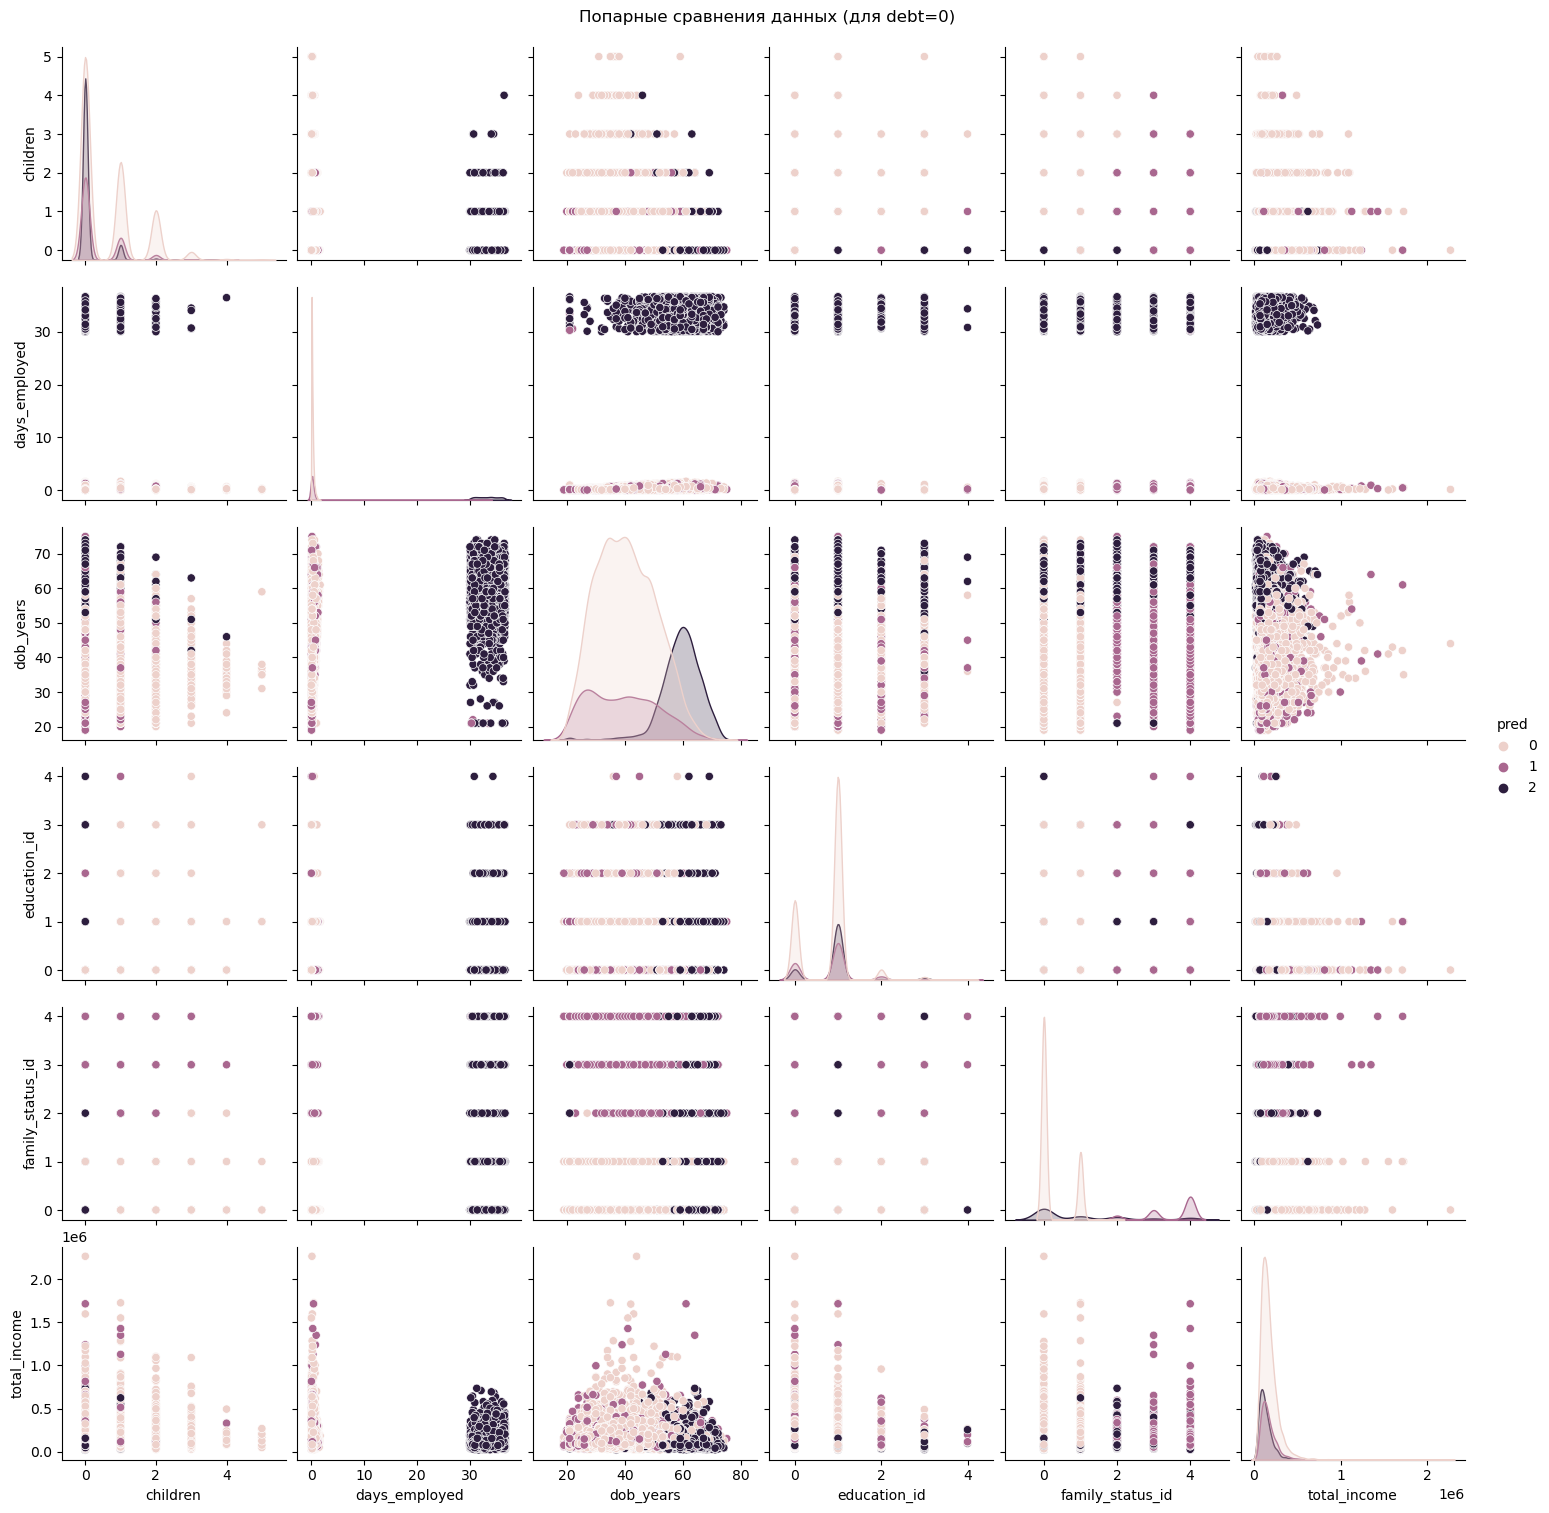

In [42]:
g = sns.pairplot(dataframe_debt_0[['children', 'days_employed','dob_years','education_id','family_status_id','total_income', "pred"]], hue="pred")
g.fig.suptitle("Попарные сравнения данных (для debt=0)", y=1.01)
plt.show()

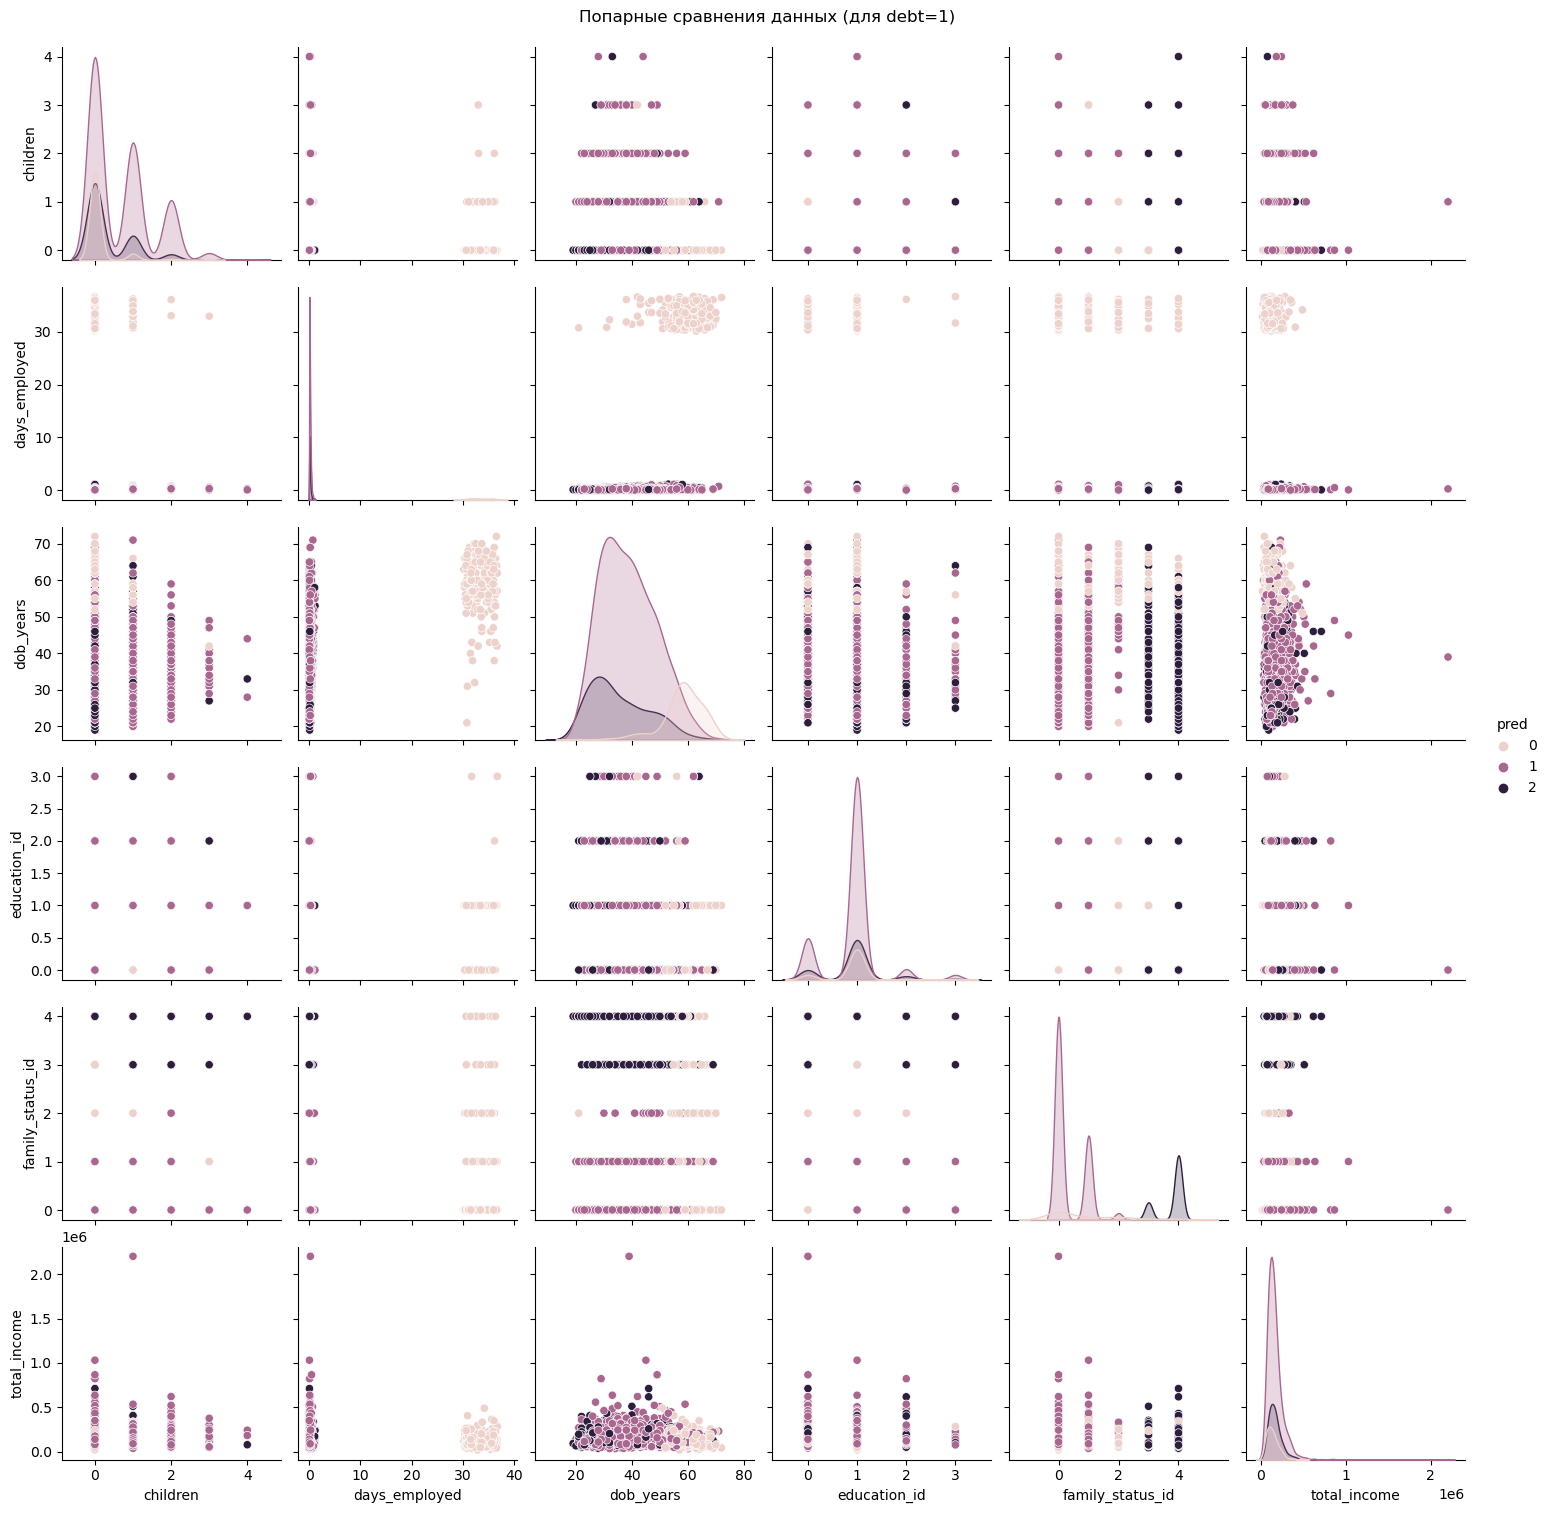

In [41]:
g = sns.pairplot(dataframe_debt_1[['children', 'days_employed','dob_years','education_id','family_status_id','total_income', "pred"]], hue="pred")
g.fig.suptitle("Попарные сравнения данных (для debt=1)", y=1.01)
plt.show()

## 2. Построить портреты клиентов.

### 1) Анализ дохода по кластерам

In [43]:
# Анализ дохода по кластерам для debt=0
dataframe_debt_0.groupby(["pred"])['total_income'].agg(['count', 'mean', 'min', 'max', 'std'])

,count,mean,min,max,std
pred,,,,,
0,11377,175411.570962,21367.648356,2.265604e+06,106618.874203
1,3143,172198.182019,32606.461486,1.715018e+06,104559.134970
2,3259,136998.228498,21205.280566,7.351033e+05,80580.709764


**Вывод (debt=0):**

* Для первого класса характерен средний доход
* Для второго класса характерен самый высокий доход
* Для третьего класса характерен наименьший доход

In [44]:
# Анализ дохода по кластерам для debt=1
dataframe_debt_1.groupby(["pred"])['total_income'].agg(['count', 'mean', 'min', 'max', 'std'])

,count,mean,min,max,std
pred,,,,,
0,182,139402.387315,20667.263793,4.901547e+05,74157.509593
1,1082,165467.150714,33941.767305,2.200852e+06,110331.937598
2,307,168810.481174,39154.156961,7.118662e+05,85366.240352


**Вывод (debt=1):**

* Для первого класса характерен наименьший доход
* Для второго класса характерен самый высокий доход
* Для третьего класса характерен средний доход

### 2) Анализ возраста клиентов по кластерам

In [45]:
# Анализ возраста клиентов по кластерам для debt=0
dataframe_debt_0.groupby(["pred"])['dob_years'].agg(['count', 'mean', 'min', 'max', 'std'])

,count,mean,min,max,std
pred,,,,,
0,11377,40.321350,19,74,10.005252
1,3143,39.273306,19,75,11.711200
2,3259,59.336299,21,74,6.701095


**Вывод (debt=0):**

* Первый и второй кластеры примерно равны по возрасту 
* Для третьего класса характерен наибольшой возраст

In [46]:
# Анализ возраста клиентов по кластерам для debt=1
dataframe_debt_1.groupby(["pred"])['dob_years'].agg(['count', 'mean', 'min', 'max', 'std'])

,count,mean,min,max,std
pred,,,,,
0,182,58.131868,21,72,7.734844
1,1082,38.730129,20,71,9.827993
2,307,35.459283,19,69,10.445977


**Вывод (debt=1):**

* Для первого класса характерен наибольшой возраст
* Второй и третий кластеры примерно равны по возрасту 

### 3) Анализ количества детей у клиентов по кластерам

In [47]:
# Анализ количества детей у клиентов по кластерам для debt=0
dataframe_debt_0.groupby(["pred"])['children'].agg(['count', 'mean', 'min', 'max', 'std'])

,count,mean,min,max,std
pred,,,,,
0,11377,0.628637,0,5,0.828997
1,3143,0.305759,0,4,0.577855
2,3259,0.095428,0,4,0.335775


**Вывод (debt=0):**

* Для первого класса характерено наибольшее количество детей
* Для второго класса характерено среднее количество детей
* Для третьего класса характерено минимальное количество детей

In [49]:
# Анализ количества детей у клиентов по кластерам для debt=1
dataframe_debt_1.groupby(["pred"])['children'].agg(['count', 'mean', 'min', 'max', 'std'])

,count,mean,min,max,std
pred,,,,,
0,182,0.104396,0,3,0.386345
1,1082,0.671904,0,4,0.810732
2,307,0.361564,0,4,0.643891


**Вывод (debt=1):**

* Для первого класса характерено минимальное количество детей
* Для второго класса характерено наибольшее количество детей
* Для третьего класса характерено среднее количество детей

### Итог по портретам клиентов

In [50]:
dataframe_debt_0.groupby(["pred"])[['total_income', 'dob_years', 'children']].agg(['count', 'mean', 'min', 'max', 'std'])

total_income                                                            \
            count           mean           min           max            std   
pred                                                                          
0           11377  175411.570962  21367.648356  2.265604e+06  106618.874203   
1            3143  172198.182019  32606.461486  1.715018e+06  104559.134970   
2            3259  136998.228498  21205.280566  7.351033e+05   80580.709764   

     dob_years                               children                    \
         count       mean min max        std    count      mean min max   
pred                                                                      
0        11377  40.321350  19  74  10.005252    11377  0.628637   0   5   
1         3143  39.273306  19  75  11.711200     3143  0.305759   0   4   
2         3259  59.336299  21  74   6.701095     3259  0.095428   0   4   

                
           std  
pred            
0     0.828997  
1     0.577855  
2     0.335775

**Итоговый вывод по портретам клиентов (debt=0):**

* В первый класс попали люди с средним доходом, с примерно равным второму классу возрастом и наибольшим количеством детей
* Во второй класс попали люди с наивысшим доходом, с примерно равным первому классу возрастом и средним количеством детей
* В третий класс попали люди с наименьшим доходом, максимальным возрастом и минимальным количеством детей

In [51]:
dataframe_debt_1.groupby(["pred"])[['total_income', 'dob_years', 'children']].agg(['count', 'mean', 'min', 'max', 'std'])

total_income                                                            \
            count           mean           min           max            std   
pred                                                                          
0             182  139402.387315  20667.263793  4.901547e+05   74157.509593   
1            1082  165467.150714  33941.767305  2.200852e+06  110331.937598   
2             307  168810.481174  39154.156961  7.118662e+05   85366.240352   

     dob_years                               children                    \
         count       mean min max        std    count      mean min max   
pred                                                                      
0          182  58.131868  21  72   7.734844      182  0.104396   0   3   
1         1082  38.730129  20  71   9.827993     1082  0.671904   0   4   
2          307  35.459283  19  69  10.445977      307  0.361564   0   4   

                
           std  
pred            
0     0.386345  
1     0.810732  
2     0.643891

**Итоговый вывод по портретам клиентов (debt=1):**

* В первый класс попали люди с наименьшим доходом, наивысшим возрастом и минимальным количеством детей
* Во второй класс попали люди с наивысшим доходом, примерно равным третьему классу возрастом и наибольшим количеством детей
* В третий класс попали люди с средним доходом, примерно равным второму классу возрастом и средним количеством детей

## 3. Постройте модель логистической регрессии на основе всей совокупности данных:

* выполните кодирование переменных (.get_dummies(df)), 

* выполните трансформацию (нормировку) переменных (StandardScaler),

* разбейте набор данных на матрицу объясняющих переменных и вектор значений целевой переменной,

* оценить качество построенного уравнения регрессии.

In [15]:
dataframe = pd.read_csv("data_correct.csv", index_col=0).iloc[:, :12]
df_2 = pd.get_dummies(dataframe)

In [16]:
X = df_2.drop(['debt'], axis=1)
y = df_2['debt']

In [17]:
scaler = StandardScaler()
scaler.fit(X)
X_s = scaler.transform(X)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_s,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)

In [19]:
model = LogisticRegression(solver='liblinear', penalty='l2')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3557
           1       0.00      0.00      0.00       313

    accuracy                           0.92      3870
   macro avg       0.46      0.50      0.48      3870
weighted avg       0.84      0.92      0.88      3870



**Вывод: модель с 96% точностью научилась определять класс "0", но с точностью 0% научилась определять класс "1"**

## 4. Сформируйте сбалансированную выборку, выполните п.2 для сбалансированной выборки.
## 6. Постройте модель дерева решений. Оцените качество построенной модели.

In [21]:
def build_and_test(X_tr, X_te, y_tr, y_te, class_weight=None, threshold=False):
    pca = PCA(n_components=2)
    pca.fit(X_tr)
    X_pca = pca.transform(X_tr)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_tr, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
    plt.show()
    if class_weight:
        model = DecisionTreeClassifier(class_weight=class_weight)
    else:
        model = DecisionTreeClassifier()
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_te)

    y_score = model.predict_proba(X_te)
    fpr0, tpr0, thresholds = roc_curve(y_te, y_score[:, 1])
    roc_auc0 = auc(fpr0, tpr0)

    best_threshold = None
    if threshold:
        J = tpr0 - fpr0
        ix = argmax(J)
        best_threshold = thresholds[ix]
        y_score = np.array([[1, y[1]] if y[0] >= best_threshold else [0, y[1]] for y in y_score])

    plot_roc(y_te, y_score)
    plt.show()

    plot_precision_recall(y_te, y_score)
    plt.show()

    plot_cumulative_gain(y_te, y_score)
    plt.show()

    plot_lift_curve(y_te, y_score)
    plt.show()

    print(classification_report(y_te, y_pred))
    return roc_auc0, fpr0, tpr0, best_threshold

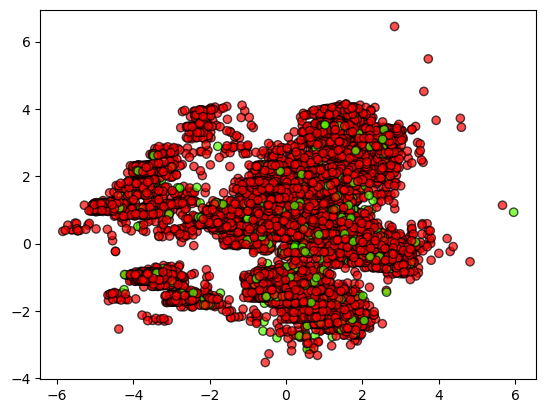

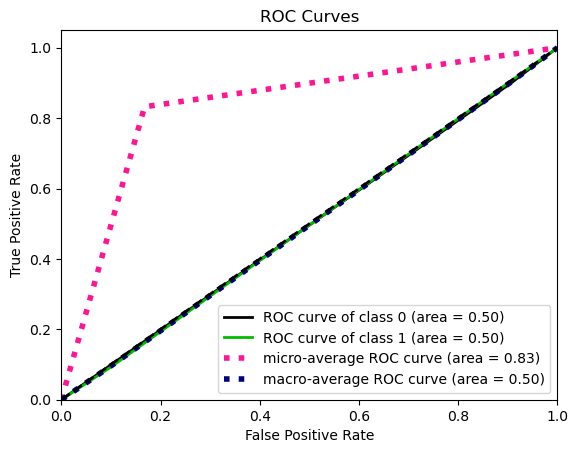

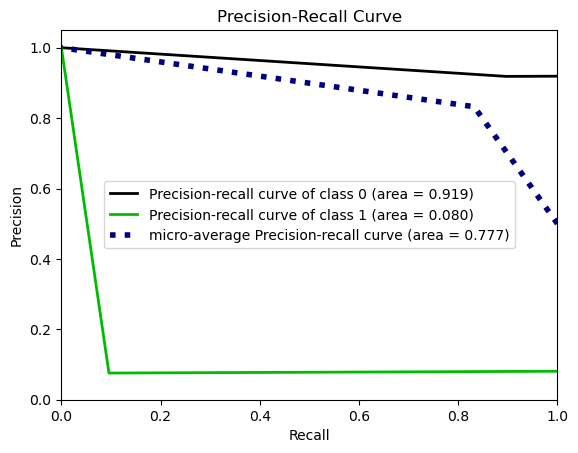

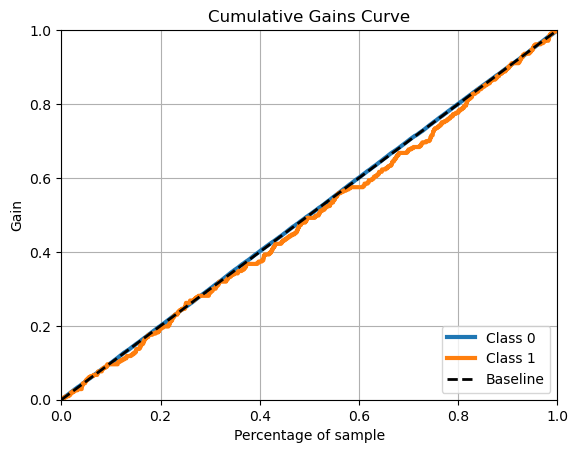

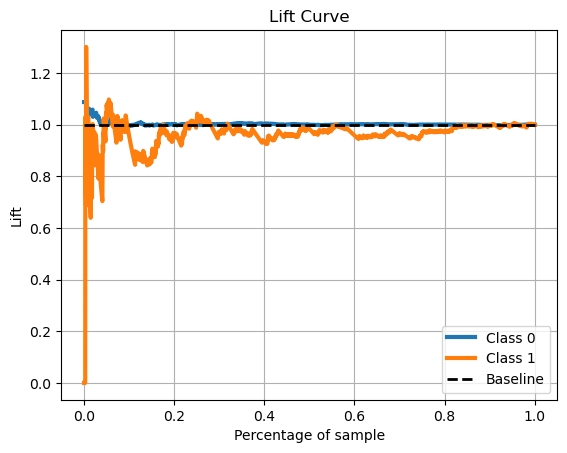

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3557
           1       0.08      0.10      0.08       313

    accuracy                           0.83      3870
   macro avg       0.50      0.50      0.50      3870
weighted avg       0.85      0.83      0.84      3870



In [22]:
roc_auc_imb, fpr_imb, tpr_imb, _ = build_and_test(X_train,
                                                  X_test,
                                                  y_train,
                                                  y_test)

**Вывод: несбалансированная модель с 91% точностью научилась определять класс "0", но с точностью 8% научилась определять класс "1"**

In [23]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Количество тренировочных данных: {Counter(y_res)}")
print(f"Количество тестовых данных: {Counter(y_test)}")

Количество тренировочных данных: Counter({0: 14222, 1: 14222})
Количество тестовых данных: Counter({0: 3557, 1: 313})


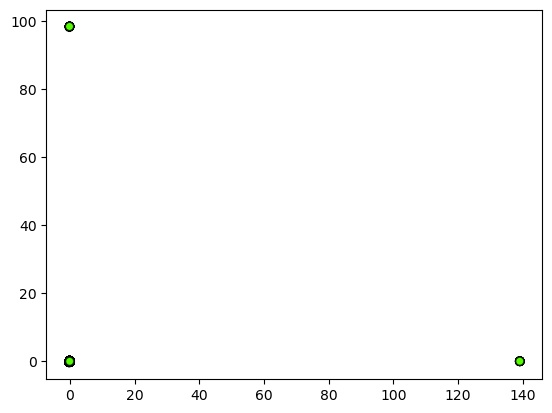

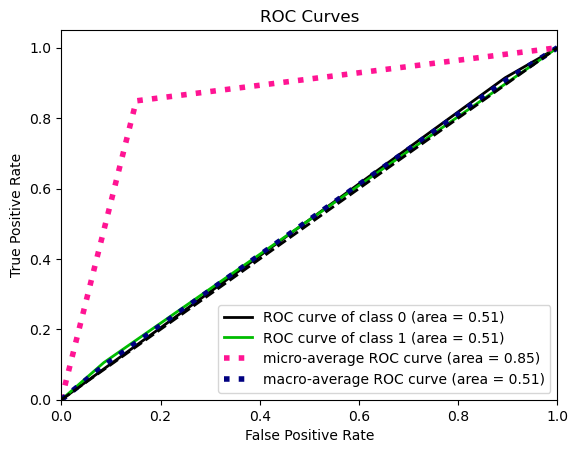

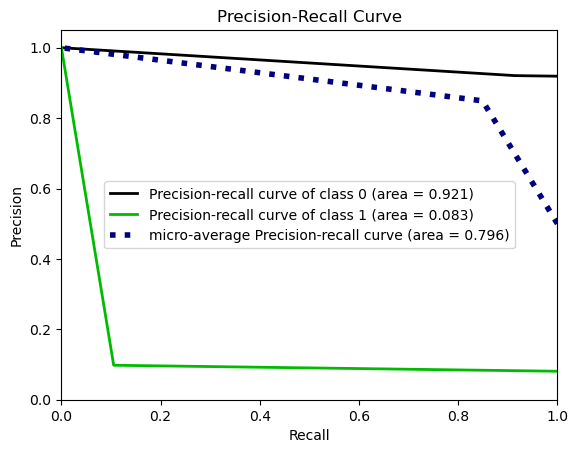

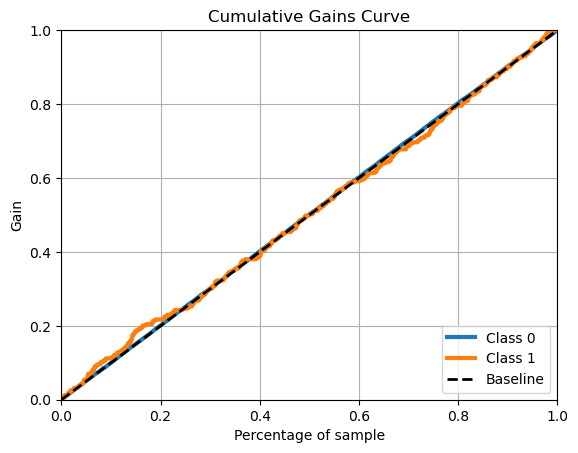

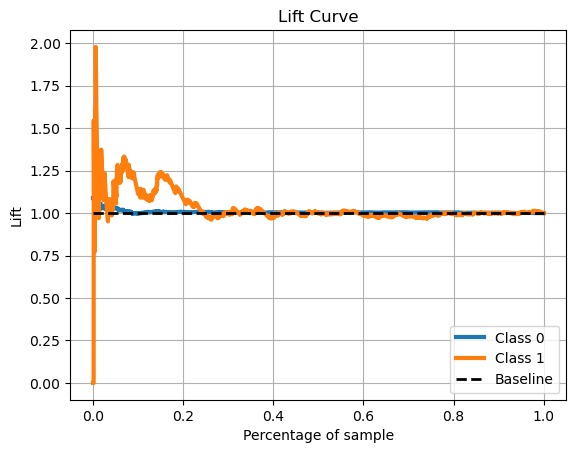

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3557
           1       0.10      0.11      0.10       313

    accuracy                           0.85      3870
   macro avg       0.51      0.51      0.51      3870
weighted avg       0.85      0.85      0.85      3870



In [24]:
roc_auc_ros, fpr_ros, tpr_ros, _ = build_and_test(X_res, X_test, y_res, y_test)

**Вывод: сбалансирвоанная модель методом RandomOverSampler с 92% точностью научилась определять класс "0", но с точностью 10% научилась определять класс "1"**

In [25]:
over_sampler = SMOTE(k_neighbors=2)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Количество тренировочных данных: {Counter(y_res)}")
print(f"Количество тестовых данных: {Counter(y_test)}")

Количество тренировочных данных: Counter({0: 14222, 1: 14222})
Количество тестовых данных: Counter({0: 3557, 1: 313})


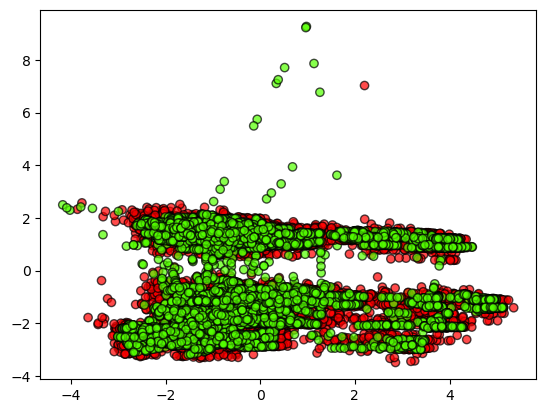

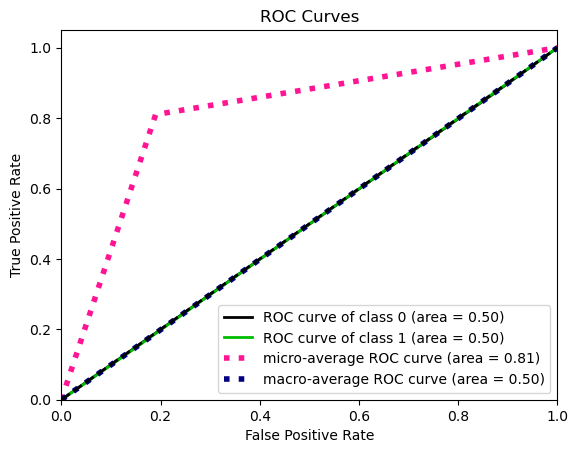

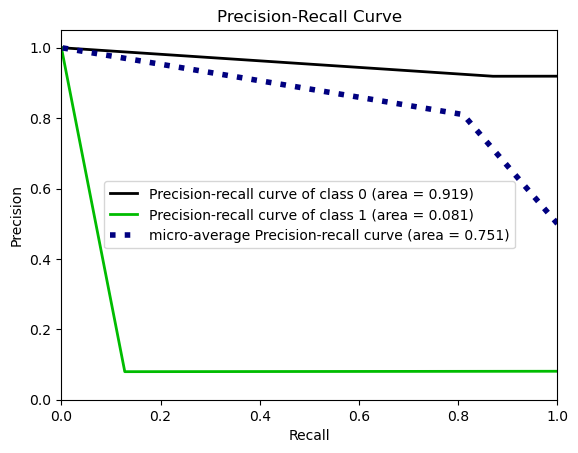

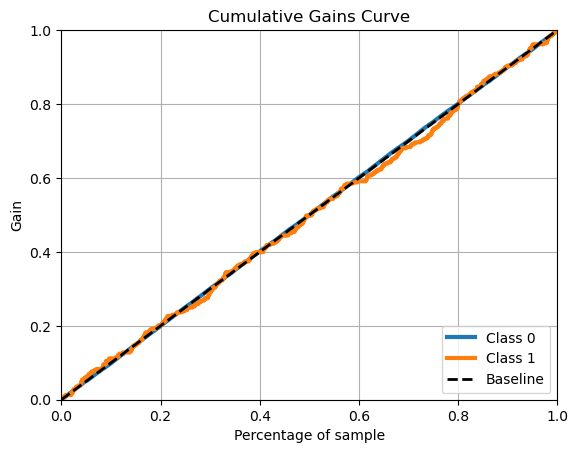

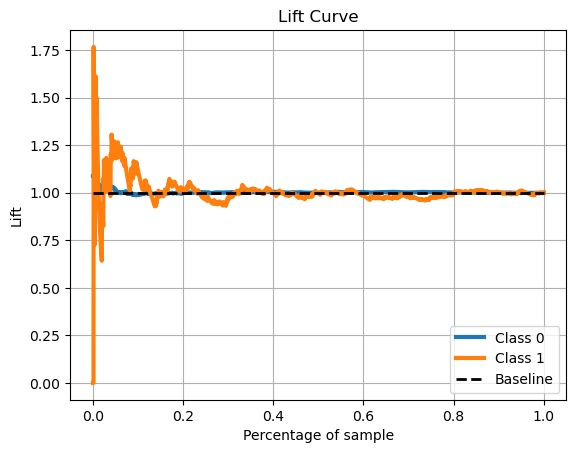

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      3557
           1       0.08      0.13      0.10       313

    accuracy                           0.81      3870
   macro avg       0.50      0.50      0.50      3870
weighted avg       0.85      0.81      0.83      3870



In [26]:
roc_auc_smote, fpr_smote, tpr_smote, _ = build_and_test(X_res,
                                                        X_test,
                                                        y_res,
                                                        y_test)

**Вывод: сбалансирвоанная модель методом SMOTE с 89% точностью научилась определять класс "0", но с точностью 10% научилась определять класс "1"**

In [27]:
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X_train, y_train)
print(f"Количество тренировочных данных: {Counter(y_res)}")
print(f"Количество тестовых данных: {Counter(y_test)}")

Количество тренировочных данных: Counter({0: 1258, 1: 1258})
Количество тестовых данных: Counter({0: 3557, 1: 313})


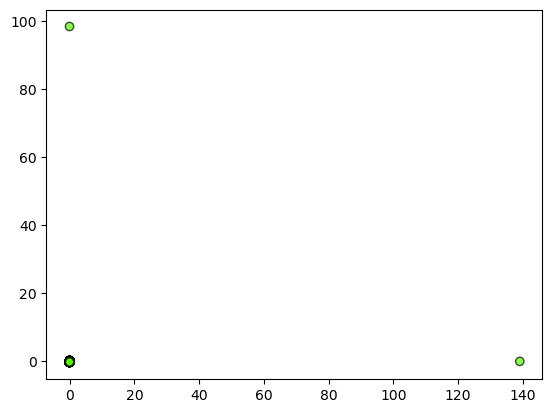

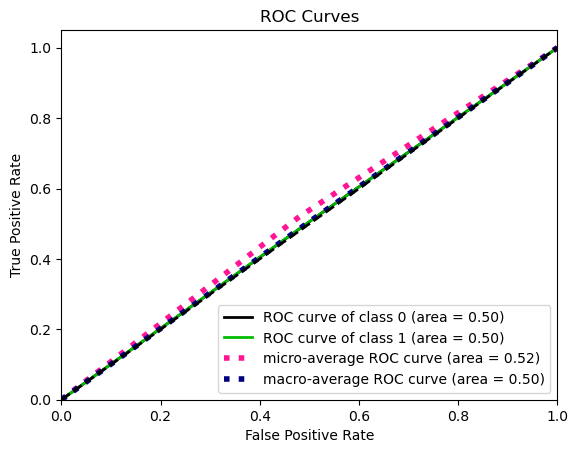

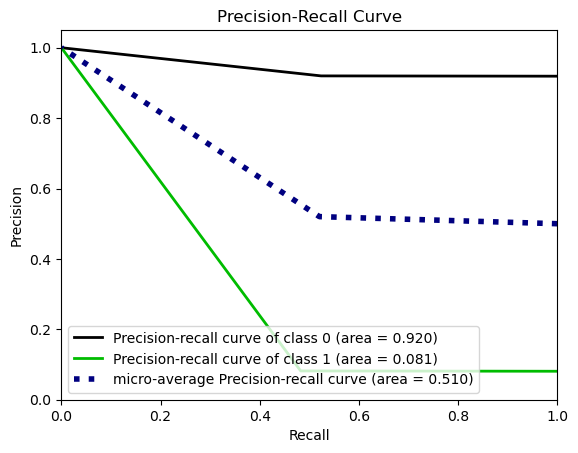

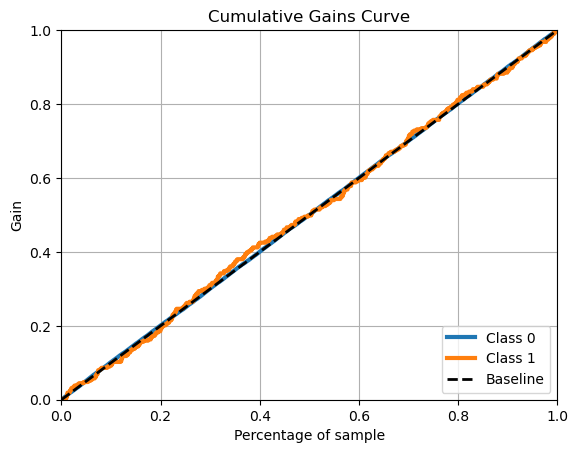

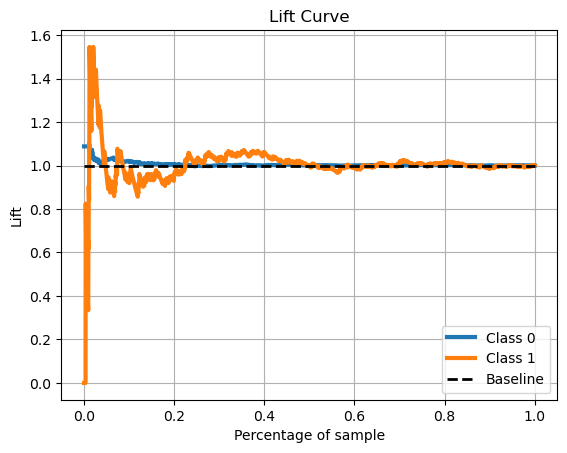

              precision    recall  f1-score   support

           0       0.92      0.52      0.67      3557
           1       0.08      0.48      0.14       313

    accuracy                           0.52      3870
   macro avg       0.50      0.50      0.40      3870
weighted avg       0.85      0.52      0.62      3870



In [28]:
roc_auc_rus, fpr_rus, tpr_rus, _ = build_and_test(X_res, X_test, y_res, y_test)

**Вывод: сбалансирвоанная модель методом RandomUnderSampler с 67% точностью научилась определять класс "0", но с точностью 14% научилась определять класс "1"**

In [29]:
under_sampler = NearMiss()
X_res, y_res = under_sampler.fit_resample(X_train, y_train)
print(f"Количество тренировочных данных: {Counter(y_res)}")
print(f"Количество тестовых данных: {Counter(y_test)}")

Количество тренировочных данных: Counter({0: 1258, 1: 1258})
Количество тестовых данных: Counter({0: 3557, 1: 313})


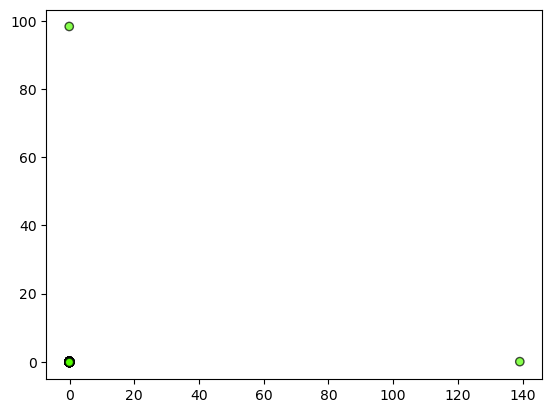

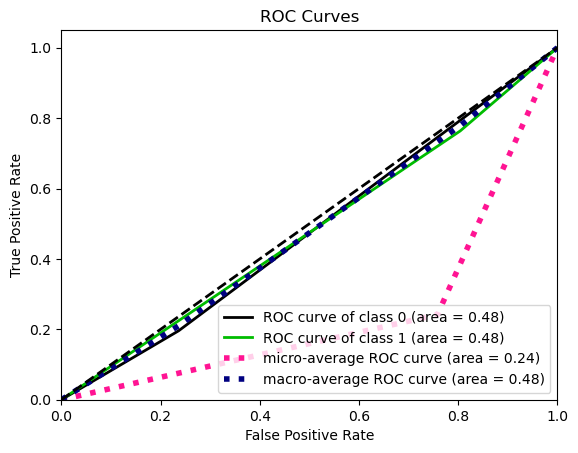

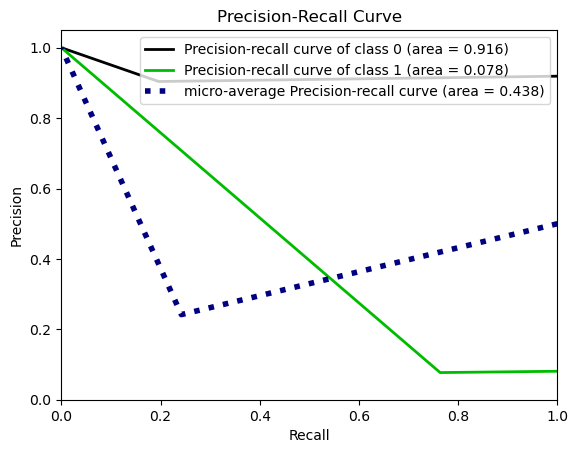

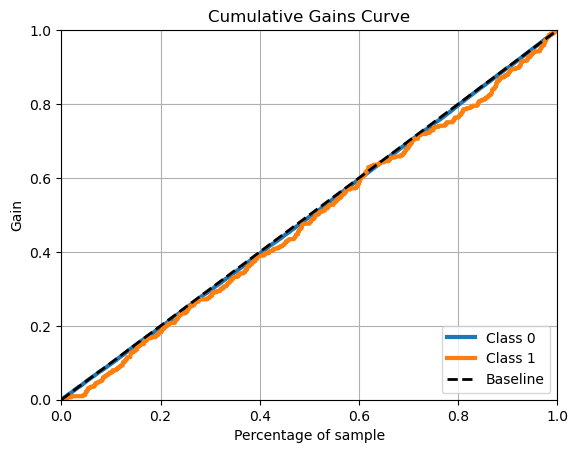

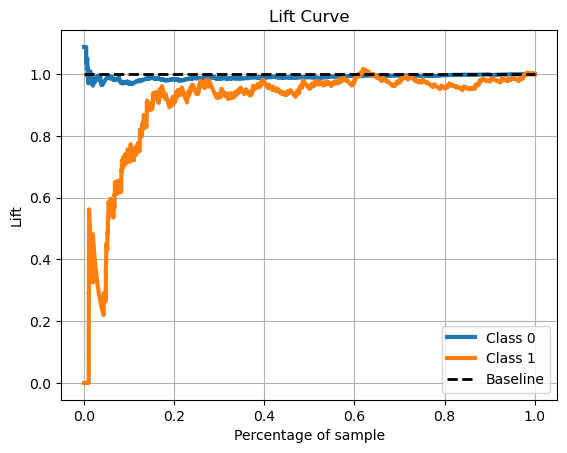

              precision    recall  f1-score   support

           0       0.90      0.20      0.32      3557
           1       0.08      0.76      0.14       313

    accuracy                           0.24      3870
   macro avg       0.49      0.48      0.23      3870
weighted avg       0.84      0.24      0.31      3870



In [30]:
roc_auc_nm, fpr_nm, tpr_nm, _ = build_and_test(X_res, X_test, y_res, y_test)

**Вывод: сбалансирвоанная модель методом NearMiss с 32% точностью научилась определять класс "0", но с точностью 14% научилась определять класс "1"**

In [31]:
n = Counter(y_train)
ratio = int(n[0]/n[1])
ratio, n

(11, Counter({0: 14222, 1: 1258}))

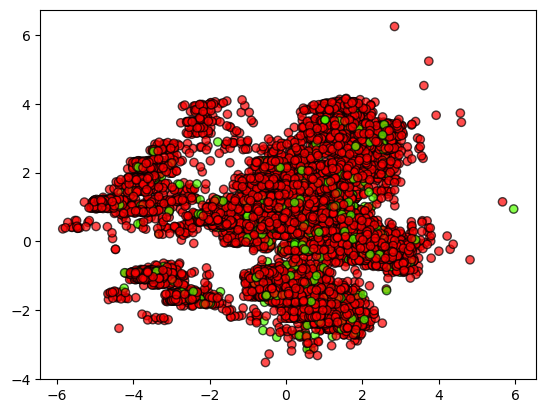

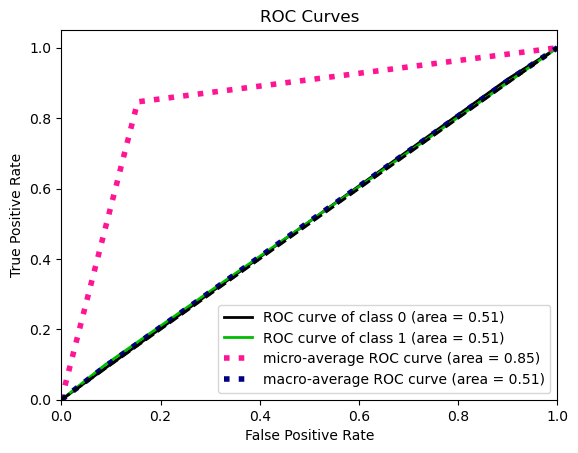

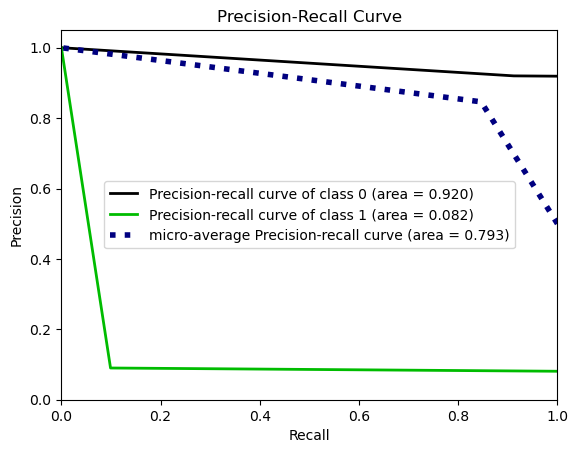

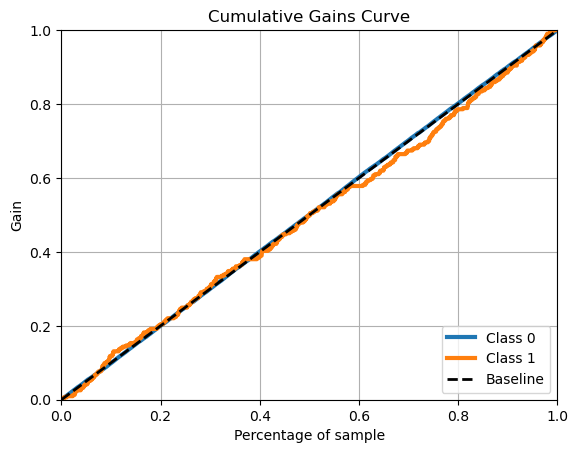

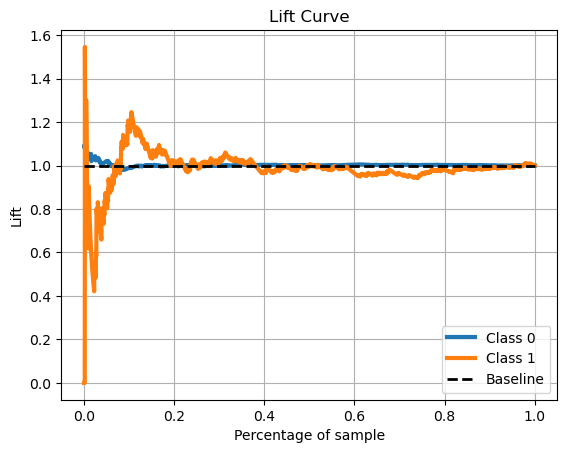

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3557
           1       0.09      0.10      0.09       313

    accuracy                           0.85      3870
   macro avg       0.51      0.51      0.51      3870
weighted avg       0.85      0.85      0.85      3870



In [32]:
roc_auc_cw, fpr_cw, tpr_cw, _ = build_and_test(X_train,
                                               X_test,
                                               y_train,
                                               y_test,
                                               class_weight={0: 1, 1: ratio})

**Вывод: сбалансирвоанная модель методом распределение весов класса с 92% точностью научилась определять класс "0", но с точностью 9% научилась определять класс "1"**

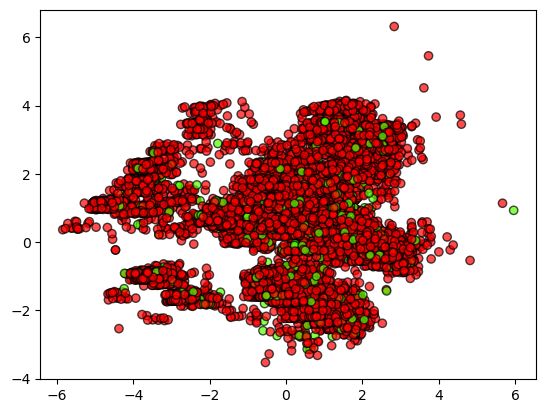

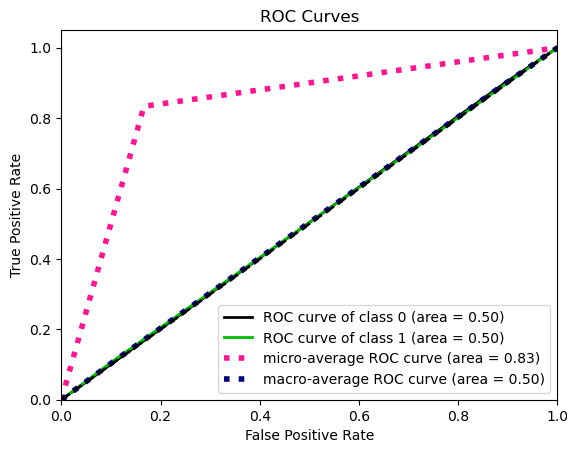

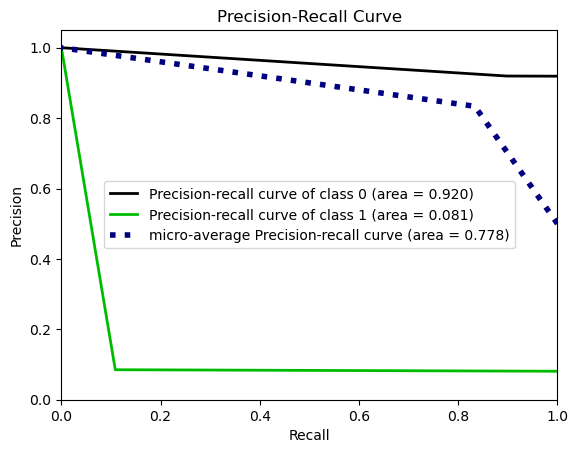

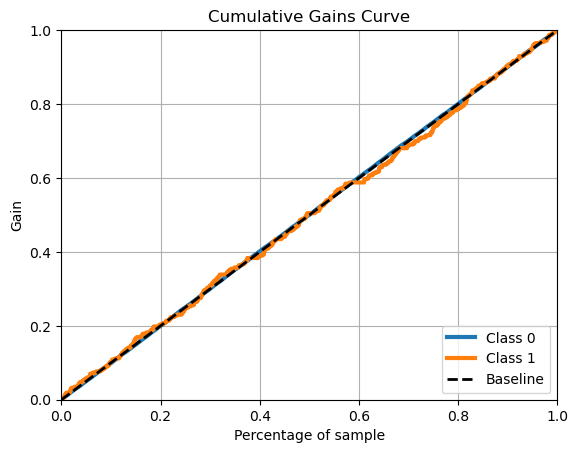

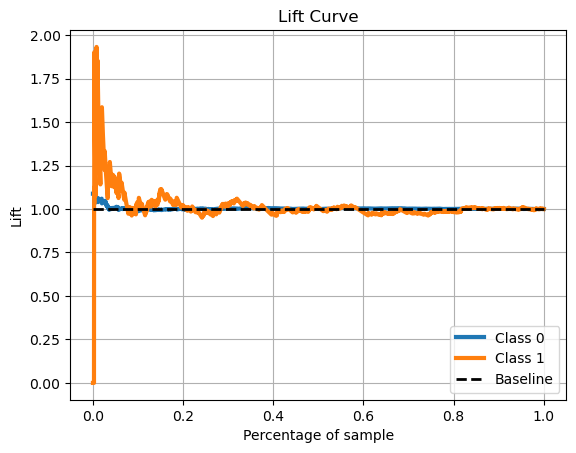

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3557
           1       0.09      0.11      0.10       313

    accuracy                           0.83      3870
   macro avg       0.50      0.50      0.50      3870
weighted avg       0.85      0.83      0.84      3870

Лучший Treshold: 1.0


In [33]:
roc_auc_thr, fpr_thr, tpr_thr, threshold = build_and_test(X_train,
                                                          X_test,
                                                          y_train,
                                                          y_test,
                                                          threshold=True)
print(f"Лучший Treshold: {threshold}")

**Вывод: сбалансирвоанная модель с порогом (Treshold) с 91% точностью научилась определять класс "0", но с точностью 10% научилась определять класс "1"**

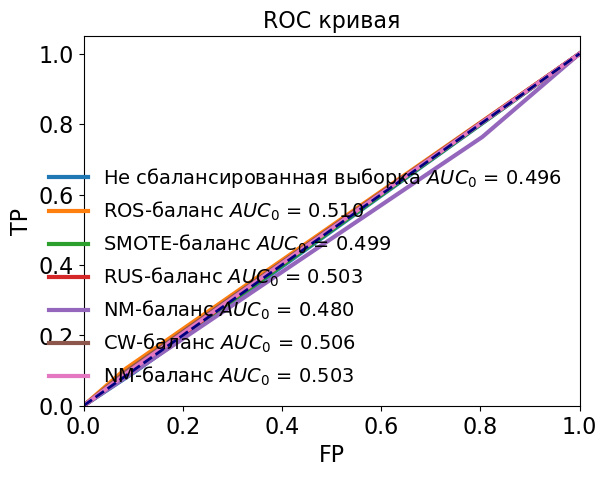

In [34]:
plt.plot(fpr_imb, tpr_imb, lw=3, label='Не сбалансированная выборка $AUC_0$ = %.3f' % (roc_auc_imb))
plt.plot(fpr_ros, tpr_ros, lw=3, label='ROS-баланс $AUC_0$ = %.3f' % (roc_auc_ros))
plt.plot(fpr_smote, tpr_smote, lw=3, label='SMOTE-баланс $AUC_0$ = %.3f' % (roc_auc_smote))
plt.plot(fpr_rus, tpr_rus, lw=3, label='RUS-баланс $AUC_0$ = %.3f' % (roc_auc_rus))
plt.plot(fpr_nm, tpr_nm, lw=3, label='NM-баланс $AUC_0$ = %.3f' % (roc_auc_nm))
plt.plot(fpr_cw, tpr_cw, lw=3, label='CW-баланс $AUC_0$ = %.3f' % (roc_auc_cw))
plt.plot(fpr_thr, tpr_thr, lw=3, label='NM-баланс $AUC_0$ = %.3f' % (roc_auc_thr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP', fontsize=16)
plt.ylabel('TP', fontsize=16)
plt.title('ROC кривая', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

**Вывод: как видно из оценок полученных моделей, ни один из представленных методов балансирования выборки не смог дать хорошего результата**

## 5. Сформируйте выборки наблюдений по целям кредитования. Постройте модели логистической регрессии по сформированным выборкам наблюдений в зависимости от целей кредитования. Оцените качество построенных уравнений регрессии. Сделайте выводы.

In [35]:
df_2

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income,education_высшее,education_начальное,education_неоконченное высшее,...,income_type_госслужащий,income_type_компаньон,income_type_пенсионер,income_type_предприниматель,income_type_сотрудник,income_type_студент,purpose_автомобиль,purpose_жильё,purpose_образование,purpose_свадьба
0,1,0.770564,42,0,0,0,253875.639453,1,0,0,...,0,0,0,0,1,0,0,1,0,0
1,1,0.367562,36,1,0,0,112080.014102,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,0,0.513555,33,1,0,0,145885.952297,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,3,0.376689,32,1,0,0,267628.550329,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,31.074527,53,1,1,0,158616.077870,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,0.413636,43,1,1,0,224791.862382,0,0,0,...,0,1,0,0,0,0,0,1,0,0
21521,0,31.409809,67,1,0,0,155999.806512,0,0,0,...,0,0,1,0,0,0,1,0,0,0
21522,1,0.193000,38,1,1,1,89672.561153,0,0,0,...,0,0,0,0,1,0,0,1,0,0
21523,3,0.284245,38,1,0,1,244093.050500,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [36]:
X_housing = df_2[df_2["purpose_жильё"] == 1].drop(["debt",
                                                   "purpose_автомобиль",
                                                   "purpose_жильё",
                                                   "purpose_образование",
                                                   "purpose_свадьба"], axis=1)
y_housing = df_2[df_2["purpose_жильё"] == 1]["debt"]
scaler = StandardScaler()
scaler.fit(X_housing)
X_housing = scaler.transform(X_housing)

X_automobile = df_2[df_2["purpose_автомобиль"] == 1].drop(["debt",
                                                           "purpose_автомобиль",
                                                           "purpose_жильё",
                                                           "purpose_образование",
                                                           "purpose_свадьба"], axis=1)
y_automobile = df_2[df_2["purpose_автомобиль"] == 1]["debt"]
scaler = StandardScaler()
scaler.fit(X_automobile)
X_automobile = scaler.transform(X_automobile)

X_education = df_2[df_2["purpose_образование"] == 1].drop(["debt",
                                                           "purpose_автомобиль",
                                                           "purpose_жильё",
                                                           "purpose_образование",
                                                           "purpose_свадьба"], axis=1)
y_education = df_2[df_2["purpose_образование"] == 1]["debt"]
scaler = StandardScaler()
scaler.fit(X_education)
X_education = scaler.transform(X_education)

X_wedding = df_2[df_2["purpose_свадьба"] == 1].drop(["debt",
                                                     "purpose_автомобиль",
                                                     "purpose_жильё",
                                                     "purpose_образование",
                                                     "purpose_свадьба"], axis=1)
y_wedding = df_2[df_2["purpose_свадьба"] == 1]["debt"]
scaler = StandardScaler()
scaler.fit(X_wedding)
X_wedding = scaler.transform(X_wedding)

In [37]:
X_train_housing, X_test_housing, y_train_housing, y_test_housing = train_test_split(
    X_housing,
    y_housing,
    test_size=0.2,
    random_state=0)

X_train_automobile, X_test_automobile, y_train_automobile, y_test_automobile = train_test_split(
    X_automobile,
    y_automobile,
    test_size=0.2,
    random_state=0)

X_train_education, X_test_education, y_train_education, y_test_education = train_test_split(
    X_education,
    y_education,
    test_size=0.2,
    random_state=0)

X_train_wedding, X_test_wedding, y_train_wedding, y_test_wedding = train_test_split(
    X_wedding,
    y_wedding,
    test_size=0.2,
    random_state=0)

In [38]:
model = LogisticRegression(solver='liblinear', penalty='l2')
model.fit(X_train_housing, y_train_housing)
y_pred = model.predict(X_test_housing)
print("Жильё")
print(classification_report(y_test_housing, y_pred))

model = LogisticRegression(solver='liblinear', penalty='l2')
model.fit(X_train_automobile, y_train_automobile)
y_pred = model.predict(X_test_automobile)
print("Автомобиль")
print(classification_report(y_test_automobile, y_pred))

model = LogisticRegression(solver='liblinear', penalty='l2')
model.fit(X_train_education, y_train_education)
y_pred = model.predict(X_test_education)
print("Образование")
print(classification_report(y_test_education, y_pred))

model = LogisticRegression(solver='liblinear', penalty='l2')
model.fit(X_train_wedding, y_train_wedding)
y_pred = model.predict(X_test_wedding)
print("Свадьба")
print(classification_report(y_test_wedding, y_pred))

Жильё
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1818
           1       0.00      0.00      0.00       134

    accuracy                           0.93      1952
   macro avg       0.47      0.50      0.48      1952
weighted avg       0.87      0.93      0.90      1952

Автомобиль
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       696
           1       0.00      0.00      0.00        84

    accuracy                           0.89       780
   macro avg       0.45      0.50      0.47       780
weighted avg       0.80      0.89      0.84       780

Образование
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       667
           1       0.00      0.00      0.00        53

    accuracy                           0.93       720
   macro avg       0.46      0.50      0.48       720
weighted avg       0.86      0.93      0.89  

**Вывод: разделение датасета на цели кредитования не дало хорошего результата**

In [39]:
# Попробуем сбалансировать с помощью ROS
over_sampler = RandomOverSampler()
X_train_housing, y_train_housing = over_sampler.fit_resample(X_train_housing, y_train_housing)
model = LogisticRegression(solver='liblinear', penalty='l2')
model.fit(X_train_housing, y_train_housing)
y_pred = model.predict(X_test_housing)
print("Жильё")
print(classification_report(y_test_housing, y_pred))

over_sampler = RandomOverSampler()
X_train_automobile, y_train_automobile = over_sampler.fit_resample(X_train_automobile, y_train_automobile)
model = LogisticRegression(solver='liblinear', penalty='l2')
model.fit(X_train_automobile, y_train_automobile)
y_pred = model.predict(X_test_automobile)
print("Автомобиль")
print(classification_report(y_test_automobile, y_pred))

over_sampler = RandomOverSampler()
X_train_education, y_train_education = over_sampler.fit_resample(X_train_education, y_train_education)
model = LogisticRegression(solver='liblinear', penalty='l2')
model.fit(X_train_education, y_train_education)
y_pred = model.predict(X_test_education)
print("Образование")
print(classification_report(y_test_education, y_pred))

over_sampler = RandomOverSampler()
X_train_wedding, y_train_wedding = over_sampler.fit_resample(X_train_wedding, y_train_wedding)
model = LogisticRegression(solver='liblinear', penalty='l2')
model.fit(X_train_wedding, y_train_wedding)
y_pred = model.predict(X_test_wedding)
print("Свадьба")
print(classification_report(y_test_wedding, y_pred))

Жильё
              precision    recall  f1-score   support

           0       0.95      0.58      0.72      1818
           1       0.09      0.55      0.15       134

    accuracy                           0.58      1952
   macro avg       0.52      0.56      0.43      1952
weighted avg       0.89      0.58      0.68      1952

Автомобиль
              precision    recall  f1-score   support

           0       0.92      0.57      0.71       696
           1       0.14      0.60      0.23        84

    accuracy                           0.57       780
   macro avg       0.53      0.58      0.47       780
weighted avg       0.84      0.57      0.65       780

Образование
              precision    recall  f1-score   support

           0       0.96      0.63      0.76       667
           1       0.13      0.70      0.22        53

    accuracy                           0.63       720
   macro avg       0.55      0.66      0.49       720
weighted avg       0.90      0.63      0.72  

**Вывод: балансировка немного улучшила точность опредления класса "1", но при этом ухудшила точность класса "0". Разделение датасета на цель кредита не дала повышение точности**